In [1]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pylab as plt

## Random search Cartpole

### How long a random agent lasts in cartpole

In [2]:
#set the cartpole environment
env = gym.make('CartPole-v0')

#for each episode record how many random steps are taken before the episode ends
steps_collector = []

#play many episodes to estimate the average length of an episode with a random agent
for _ in range(1000):
    #initialize environment
    env.reset()
    #count the steps until the episode ends
    num_steps = 0
    done = False
    while not done:
        num_steps += 1
        state, reward, done, info = env.step(env.action_space.sample())
    steps_collector.append(num_steps)
    
#average steps until the episode ends, if the agent acts randomly
np.mean(steps_collector)

21.818

### Random search for the optimal policy

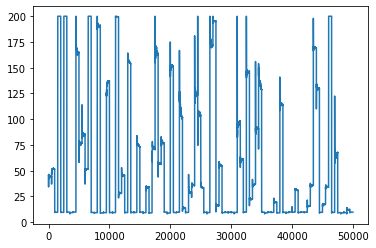

200.0


In [3]:
#defines an action function which acts with 1 if state x weights >0 otherwise 0
def choose_action(state, weights):
    if state.dot(weights) > 0:
        return 1
    else:
        return 0

max_steps = 0
steps_recorder = []

for t in range(100):
    
    #initialize random weights for choosing actions during episode
    weights = np.random.randn(env.observation_space.shape[0])

    #for each episode record how many random steps are taken before the episode ends
    steps_collector = []

    #play many episodes to estimate the average length of an episode with a random agent
    for _ in range(500):
        #initialize environment
        env.reset()
        state = env.state
        #count the steps until the episode ends
        num_steps = 0
        done = False
        while not done:
            action = choose_action(state, weights)
            num_steps += 1
            state, reward, done, info = env.step(action)
        steps_collector.append(num_steps)

        if np.mean(steps_collector) > max_steps:
            max_steps = np.mean(steps_collector)
            new_weights = weights

        steps_recorder.append(np.mean(steps_collector))

plt.plot(steps_recorder)
plt.show()
print(max_steps)

In [4]:
#check if the optimal random policy really works
env = gym.make('CartPole-v0')

env.reset()
state = env.state

num_steps = 0
done = False
while not done:
    action = choose_action(state, new_weights)
    num_steps += 1
    state, reward, done, info = env.step(action)
    
num_steps

200

## Q-Learning Cartpole

100
200
300
400
500
600
700
800
900
1000


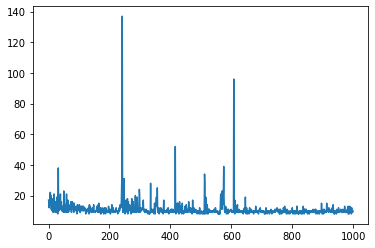

In [337]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt


class Model():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim])
        ])
    
    def predict(self, state):
        state = state.reshape(1, self.input_dim)
        return self.network(state).numpy()
    
class Agent():
    def __init__(self, input_dim, output_dim):
        self.model = Model(input_dim, output_dim)
        self.epsilon = 0.90
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.05
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self, state, next_state, reward, done):
        if done:
            target = reward
        else:
            target = reward + np.max(self.model.predict(next_state)[0])

        target_full = self.model.predict(state)
        target_full[0, np.argmax(self.model.predict(next_state)[0])] = target

        with tf.GradientTape() as tape:
            tape.watch(self.model.network.trainable_variables)
            loss = tf.reduce_mean(tf.square(target_full - self.model.network(state.reshape(1, 4))))
        gradients = tape.gradient(loss, self.model.network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.network.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        rewards_collect += 1
        agent.learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.90)
agent = Agent(4, 2)

sum_rewards = []
for t in range(1000):
    sum_rewards.append(play_one_episode())
    if (t+1) % 100 == 0:
        print(t+1)
        
plt.plot(sum_rewards)
plt.show()

## Policy Gradient Cartpole

Iteration: 50, Average return over the last 30 episodes: 22.25
Iteration: 100, Average return over the last 30 episodes: 25.84285714285714
Iteration: 150, Average return over the last 30 episodes: 28.058333333333334
Iteration: 200, Average return over the last 30 episodes: 32.83529411764706
Iteration: 250, Average return over the last 30 episodes: 37.21363636363636
Iteration: 300, Average return over the last 30 episodes: 42.89259259259259
Iteration: 350, Average return over the last 30 episodes: 48.55
Iteration: 400, Average return over the last 30 episodes: 56.78378378378378
Iteration: 450, Average return over the last 30 episodes: 65.57380952380953
Iteration: 500, Average return over the last 30 episodes: 73.29361702127659
Iteration: 550, Average return over the last 30 episodes: 81.48653846153846
Iteration: 600, Average return over the last 30 episodes: 90.09473684210526
Iteration: 650, Average return over the last 30 episodes: 97.22096774193548
Iteration: 700, Average return over 

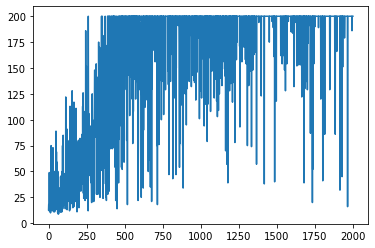

In [125]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt

class Policy():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim]) 
        ])
    
    def call(self, state):
        return self.network(state)


class Agent():
    def __init__(self, optimizer):
        self.policy = Policy(4, 2)
        self.optimizer = optimizer
        
    def act(self, state):
        state = tf.convert_to_tensor([state])
        action_probs = tf.nn.softmax(self.policy.call(state))
        return np.random.choice([0, 1], p = action_probs.numpy()[0]) 
    
    def learn(self, actions, states, rewards, discount_rate):
        with tf.GradientTape() as tape:
            tape.watch(self.policy.network.trainable_variables)
            discounted_rs = discounted_returns(rewards, discount_rate)
            logits = self.policy.call(np.array(states))
            labels = np.array(actions)
            neg_log_policy_probs = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
            loss = tf.reduce_mean(neg_log_policy_probs * discounted_rs)
        self.optimizer.minimize(loss, self.policy.network.trainable_variables, tape = tape)

    
def discounted_returns(rewards, discount_rate):
    T = len(rewards)
    return_ = 0.0

    discounted_returns = np.zeros(T)
    for t in reversed(range(T)):
        discounted_returns[t] = return_ + discount_rate * rewards[t]
        return_ = discounted_returns[t]
    
    discounted_returns -= np.mean(discounted_returns)
    discounted_returns /= np.std(discounted_returns)
    return discounted_returns


env = gym.make('CartPole-v0')
agent = Agent(tf.keras.optimizers.Adam(learning_rate = 0.01))

sum_returns = []
for i in range(2000):
    actions, states, rewards = [], [], []
    state = env.reset()
    sum_return = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        sum_return += 1
        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1.0
        actions.append(action_one_hot)
        states.append(state)
        rewards.append(reward)
        state = next_state

    agent.learn(actions, states, rewards, discount_rate = 0.95)
    sum_returns.append(sum_return)
    
    if (i+1) % 50 == 0:
        print(f'Iteration: {i+1}, Average return over the last 30 episodes: {np.mean(sum_returns[:-30])}')
        
plt.plot(sum_returns)
plt.show()